In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline


/home/sodko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 이미지 사이지를 적게 만들었습니다. (128x128x3)

In [2]:
train_path = 'data/train'
test_path = 'data/test'
valid_path = 'data/valid'
size = 128

## 데이터셋이 얼만지에 따라 batchsize을 바꾸는게 좋습니다

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(size,size), classes=['sod','cattoy','sprite'], batch_size=64)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(size,size), classes=['sod','cattoy','sprite'], batch_size=64)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(size,size), classes=['sod','cattoy','sprite'], batch_size=64)

Found 6000 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# 라벨링 결과를 보여주려고 하는 함수입니다

In [5]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [12]:
imgs, labels = next(test_batches)

## 아래와 같이 라벨링한 결과입니다

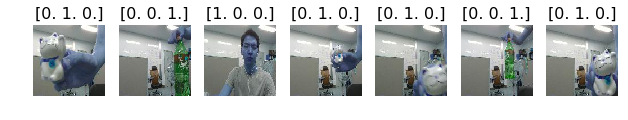

In [13]:
plots(imgs[1:8], titles=labels[1:8])

# CNN 모델을 생성합니다

### 제가 learning rate을 (0.01, 0.001, 0.0001 ...) 실행해보고 validation data에 제일 좋은 결과를 보여준 값은 0.0003입니다

## 지금 총 6'000개의 학습데이터 있고 batchsize=64니까 steps_per_epoch=94되고
## validation step은 10 (10*64 ~ 600)

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import os

#I used a smaller VGG16 without BatchNormalization model since I don't have an enough computing power(GPU)

size = 128
batchsize = 64
finalActivation = 'sigmoid'
object_names = [name for name in os.listdir('data/valid')]
class_num = int(len(object_names))

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(size, size, 3)))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(class_num, activation=finalActivation))

model.compile(optimizer=optimizers.RMSprop(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
	rescale = 1./255,
	rotation_range=30,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	zoom_range=0.2,
	horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.255)

#This is the labeling process
train_generator = train_datagen.flow_from_directory('data/train', target_size=(size,size), batch_size=batchsize, classes=object_names)
validation_generator = validation_datagen.flow_from_directory('data/valid', target_size=(size,size), batch_size=batchsize, classes=object_names)
#training
steps_train = 0
steps_valid = 0
for folder in object_names:
	steps_train += len(os.listdir('data/train/' + folder))
	steps_valid += len(os.listdir('data/valid/' + folder))

#steps_per_epoch should be training_Data_num / batch_size
model.fit_generator(train_generator, epochs=5, steps_per_epoch=(steps_train/batchsize), validation_data=validation_generator, validation_steps=(steps_valid/batchsize), workers=4)
model.save('model3.h5')


Found 6000 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/5
18/93 [====>.........................] - ETA: 3:11 - loss: 1.1882 - acc: 0.3342